<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Общая-информация" data-toc-modified-id="Общая-информация-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Общая информация</a></span></li><li><span><a href="#Библиотеки-и-функции" data-toc-modified-id="Библиотеки-и-функции-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Библиотеки и функции</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Объединение-таблиц" data-toc-modified-id="Объединение-таблиц-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Объединение таблиц</a></span></li><li><span><a href="#Корреляционный-анализ" data-toc-modified-id="Корреляционный-анализ-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Корреляционный анализ</a></span></li><li><span><a href="#Пайплайн" data-toc-modified-id="Пайплайн-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Пайплайн</a></span></li><li><span><a href="#Анализ-важности-признаков" data-toc-modified-id="Анализ-важности-признаков-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Анализ важности признаков</a></span></li><li><span><a href="#Сегментация-покупателей" data-toc-modified-id="Сегментация-покупателей-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Сегментация покупателей</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Общая информация

Интернет-магазин продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
<br>Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Библиотеки и функции

In [1]:
# активировать при ошибке во время импорта библиотек
!pip install phik  
!pip install shap
!pip install -q --upgrade scikit-learn

In [2]:
import pandas as pd   
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import shap
from sklearn.dummy import DummyClassifier

In [3]:
def read_df_csv(names, sep=','):      
    '''принимает список имен датасетов, которые находятся в директории /datasets/ 
    и помещает их в переменные data_1,_2,_3 и т.д.'''
    for i, c in enumerate(names):       
        globals().update({'data_'+str(i+1): pd.read_csv('/datasets/'+c, sep=sep)})

In [4]:
def about_df(list_df):
    '''выводит информацию о всех датасетах из списка list_df'''
    for c, i in enumerate(list_df):
        display("**** DATA_"+str(c+1)+' ****')
        display(i.info())
        display(i.describe().round(2))
        display(f'Количество дубликатов: {i.duplicated().sum()}')
        display('Количество пропущенных значений:', i.isnull().sum())

## Описание данных

Выполним загрузку датасетов

In [5]:
names = ['market_file.csv', 'market_money.csv', 'market_time.csv']
read_df_csv(names)

In [6]:
display(data_1.head(3), data_2.head(3), data_3.head(3))

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10


In [7]:
data_4 = pd.read_csv('/datasets/money.csv', sep=';')
data_4.head(3)

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"


Выведем информаию о четырех датасетах

In [8]:
dfs = [data_1, data_2, data_3, data_4]
about_df(dfs)

'**** DATA_1 ****'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

None

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00
mean,215997.50,4.25,4.01,601.90,0.32,3.27,2.84,4.19,8.18
std,375.42,1.01,0.70,249.86,0.25,1.36,1.97,1.96,3.98
min,215348.00,0.90,3.00,110.00,0.00,1.00,0.00,0.00,1.00
25%,215672.75,3.70,4.00,405.50,0.17,2.00,1.00,3.00,5.00
50%,215997.50,4.20,4.00,606.00,0.24,3.00,3.00,4.00,8.00
75%,216322.25,4.90,4.00,806.00,0.30,4.00,4.00,6.00,11.00
max,216647.00,6.60,5.00,1079.00,0.99,6.00,10.00,9.00,20.00


'Количество дубликатов: 0'

'Количество пропущенных значений:'

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

'**** DATA_2 ****'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

,id,Выручка
count,3900.00,3900.00
mean,215997.50,5025.70
std,375.33,1777.70
min,215348.00,0.00
25%,215672.75,4590.15
50%,215997.50,4957.50
75%,216322.25,5363.00
max,216647.00,106862.20


'Количество дубликатов: 0'

'Количество пропущенных значений:'

id         0
Период     0
Выручка    0
dtype: int64

'**** DATA_3 ****'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

,id,минут
count,2600.00,2600.00
mean,215997.50,13.34
std,375.35,4.08
min,215348.00,4.00
25%,215672.75,10.00
50%,215997.50,13.00
75%,216322.25,16.00
max,216647.00,23.00


'Количество дубликатов: 0'

'Количество пропущенных значений:'

id        0
Период    0
минут     0
dtype: int64

'**** DATA_4 ****'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


None

,id
count,1300.00
mean,215997.50
std,375.42
min,215348.00
25%,215672.75
50%,215997.50
75%,216322.25
max,216647.00


'Количество дубликатов: 0'

'Количество пропущенных значений:'

id         0
Прибыль    0
dtype: int64

**Вывод по разделу**
<br>Вся информация находится в четырех датасетах. 
<br>Первый содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. Состоит из 1300 строк и 13 колонок. Дубликаты и повторяющиеся значения отсутствуют.
<br>Второй содержит информацию о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом. Состоит из 3900 строк и 3 колонок. Дубликаты и повторяющиеся значения отсутствуют.
<br>Третий содержит информацию с данными о времени (в минутах), которое покупатель провёл на сайте в течение некоторого периода. Состоит из 2600 строк и 3 колонок. Дубликаты и повторяющиеся значения отсутствуют.
<br>Четвертый содержит информацию с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю. Состоит из 1300 строк и 2 колонок. Дубликаты и повторяющиеся значения отсутствуют.
<br>Имеется одно аномальное значение в data_2 (будет устранено в разделе EDA), тип данных в колонке "прибыль" в data_4 будет откорректрован в следующем разделе.

## Предобработка данных

Приведем названия колонок датафреймов к приемлемому виду 

In [9]:
data_1.columns = ['id', 'активн', 'тип_сервиса', 'разр_сообщать', 'маркет_актив_6_мес', 
                  'маркет_актив_тек_мес', 'длительность', 'по_акции', 'популярная_категория', 
                  'сред_просм_катег_за_визит', 'корзина_шт_квартал', 
                  'ошибка_сервиса', 'страниц_за_визит']
data_2.columns = ['id', 'период_выручки', 'выручка'] 
data_3.columns = ['id', 'период_времени', 'минут'] 
data_4.columns = ['id', 'прибыль'] 
display(data_1.head(3), data_2.head(3), data_3.head(3), data_4.head(3))

,id,активн,тип_сервиса,разр_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,по_акции,популярная_категория,сред_просм_катег_за_визит,корзина_шт_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5


,id,период_выручки,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0


,id,период_времени,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10


,id,прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"


Приведем в соответствие типы данных. Некорректный тип только в data_4

In [10]:
data_4['прибыль'] = data_4['прибыль'].str.replace(',', '.').astype(float)

Проверим датасеты на наличие неявных дубликатов в категориальных столбцах. Сразу будем устранять такие дубликаты

In [11]:
[data_1[i].unique() for i in ['активн', 'тип_сервиса', 'разр_сообщать', 'популярная_категория']]

[array(['Снизилась', 'Прежний уровень'], dtype=object),
 array(['премиум', 'стандартт', 'стандарт'], dtype=object),
 array(['да', 'нет'], dtype=object),
 array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
        'Техника для красоты и здоровья', 'Кухонная посуда',
        'Мелкая бытовая техника и электроника'], dtype=object)]

In [12]:
data_1['тип_сервиса'] = data_1['тип_сервиса'].replace('стандартт', 'стандарт')
data_1['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [13]:
data_2['период_выручки'].value_counts()

препредыдущий_месяц    1300
предыдущий_месяц       1300
текущий_месяц          1300
Name: период_выручки, dtype: int64

In [14]:
data_2['период_выручки'] = data_2['период_выручки'].replace('препредыдущий_месяц', 'предпредыдущий_месяц')
data_2['период_выручки'].unique()

array(['предпредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Видно, что для каждого пользователя в data_2 имеются данные за предыдущий, предпредыдущий и текущий период

In [15]:
data_3['период_времени'].value_counts()

предыдцщий_месяц    1300
текущий_месяц       1300
Name: период_времени, dtype: int64

In [16]:
data_3['период_времени'] = data_3['период_времени'].replace('предыдцщий_месяц', 'предыдущий_месяц')
data_3['период_времени'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [17]:
data_4.describe()

,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


**Вывод по разделу**
<br>В результате выполненной предобработки типы данных были откорректированы, а некорректные наименования в колонках устранены. 

## Исследовательский анализ данных

Вначале избавимся от пользователя с аномальным значением выручки из data_2

In [18]:
data_2.sort_values(by='выручка', ascending=False).head(3)

,id,период_выручки,выручка
98,215380,текущий_месяц,106862.2
435,215493,текущий_месяц,7799.4
262,215435,текущий_месяц,7605.3


In [19]:
data_2.query('id == 215380')

,id,период_выручки,выручка
96,215380,предпредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


In [20]:
# Поиск пользователей с нулевыми покупками за 3 месяца
data_2.groupby('id')['выручка'].sum().sort_values().head(3)

id
215348    3293.1
215359    4735.0
215357    5986.3
Name: выручка, dtype: float64

In [21]:
# Поиск пользователей с нулевыми покупками хотябы за 1 месяц
data_2.query('выручка == 0')['id'].unique()

array([215348, 215357, 215359])

In [22]:
# Список с id аномальных пользователей
anomaly_list = [215380, 215348, 215357, 215359]

In [23]:
[len(data_1), len(data_2), len(data_3), len(data_4)]

[1300, 3900, 2600, 1300]

In [24]:
data_1 = data_1[~data_1['id'].isin(anomaly_list)]
data_2 = data_2[~data_2['id'].isin(anomaly_list)]
data_3 = data_3[~data_3['id'].isin(anomaly_list)]
data_4 = data_4[~data_4['id'].isin(anomaly_list)]
[len(data_1), len(data_2), len(data_3), len(data_4)]

[1296, 3888, 2592, 1296]

Рассмотрим распределение пользователей по категоряиальным признакам из data_1

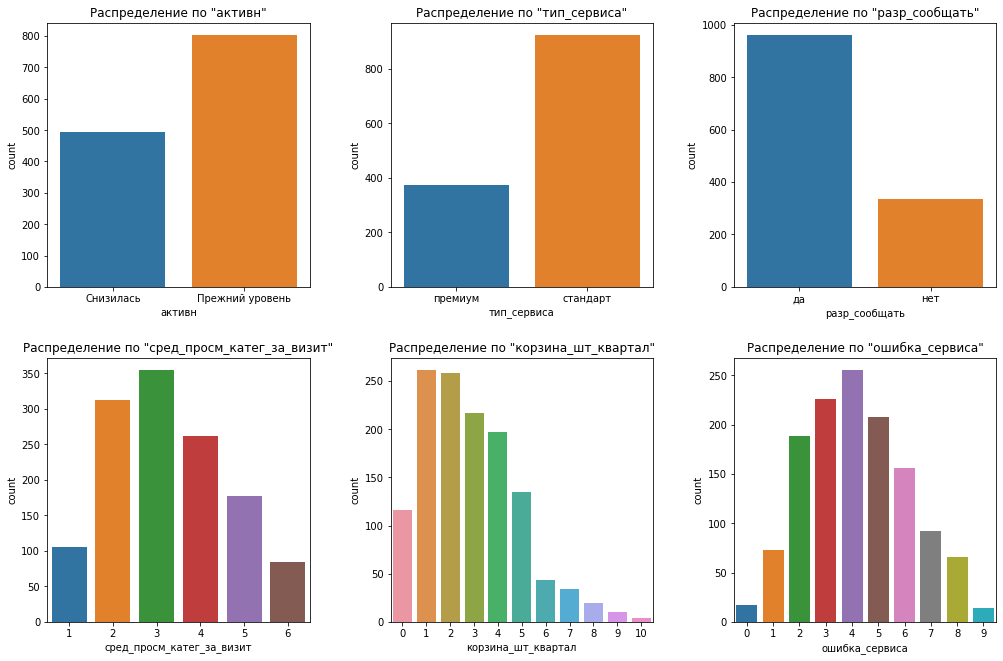

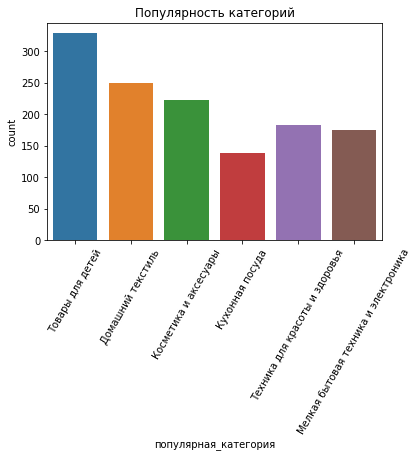

In [25]:
cat_cols = ['активн', 'тип_сервиса', 'разр_сообщать', 
            'сред_просм_катег_за_визит', 'корзина_шт_квартал', 'ошибка_сервиса']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axe = axes.ravel()
fig.tight_layout(pad=5)
for i, c in enumerate(cat_cols):
    sns.countplot(data = data_1, x=c, ax=axe[i])
    axe[i].set_xlabel(c)
    axe[i].set_title(f'Распределение по "{c}"')
plt.show()
sns.countplot(data = data_1, x='популярная_категория')
plt.title('Популярность категорий')
plt.xticks(rotation=60)
plt.show()

In [26]:
temp_1 = data_1.query('активн == "Снизилась"')
temp_2 = data_1.query('активн != "Снизилась"')

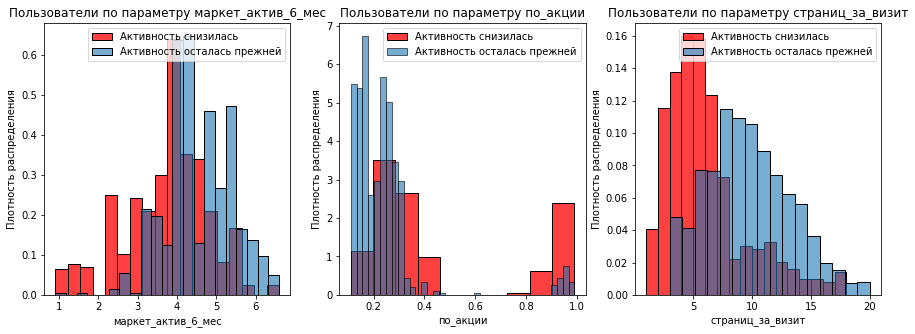

In [27]:
temp = ['маркет_актив_6_мес', 'по_акции', 'страниц_за_визит']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axe = axes.ravel()
for i, c in enumerate(temp):
    sns.histplot(data=temp_1[c], label='Активность снизилась', ax=axe[i], 
                 stat='density', common_norm=False, color='red')
    sns.histplot(data=temp_2[c], label='Активность осталась прежней', ax=axe[i], alpha=0.6, 
                 stat='density', common_norm=False)
    axe[i].set_title(f'Пользователи по параметру {c}')
    axe[i].set_xlabel(c)
    axe[i].set_ylabel('Плотность распределения')
    axe[i].legend()
plt.show()

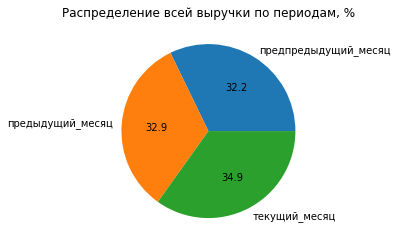

In [28]:
temp = data_2.pivot_table(index='период_выручки', values='выручка', aggfunc='sum')
plt.pie(temp['выручка'], autopct='%.1f', labels=temp.index)
plt.title('Распределение всей выручки по периодам, %');

In [29]:
data_3.head(3)

,id,период_времени,минут
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


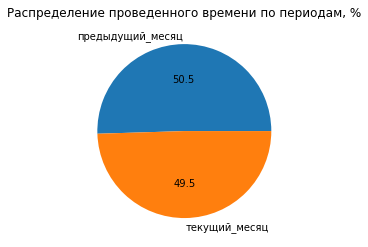

In [30]:
temp = data_3.pivot_table(index='период_времени', values='минут', aggfunc='sum')
plt.pie(temp['минут'], autopct='%.1f', labels=temp.index)
plt.title('Распределение проведенного времени по периодам, %');

In [31]:
data_4.head(3)

,id,прибыль
1,215349,4.16
2,215350,3.13
3,215351,4.87


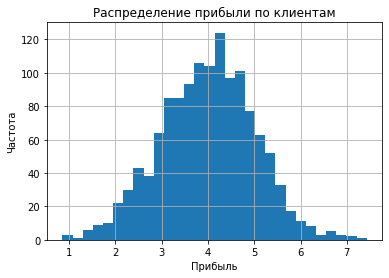

In [32]:
data_4['прибыль'].hist(bins=30)
plt.xlabel('Прибыль')
plt.ylabel('Частота')
plt.title('Распределение прибыли по клиентам');

**Вывод по разделу**
<br>Как видно из проведенного анализа большинство клиентов сохранили свою активность на прежнем уровне. Также большинство не пользуется премиальной подпиской. Большая часть пользователей интересуется дополнительными предолежниями о товаре. Средний просмотр категорий за визит имеет приблизительно номальное распределение с наиболее частым значением = 3. Чаще всего в корзине пользователей накапливается до 5 неоплаченных товаров. Число сбоев тоже имеет нормальное распределение со средним значением в районе 4 сбоев. Наиболее чаще пользователей интересуют товары для детей и домотканный текстиль. Наименее популярная категория - кухонная посуда.
<br>Имеет место дисбаланс классов при делении пользователей по покупательской активности, типе подписки, разрешению на уведомления.
<br>Пользователи, у которых активность снизилась имеют тенденцию покупать больше товаров по акциям. Судя по всему такое поведение связано с их личными финансовыми трудностями, а не с работой сервиса.
<br> Прослеживается тенденция увеличения выручки от периода к периоду, так за текущий период сервис заработал больше всего выручки (34,9 % от всей выручки за 3 месяца). При этом время проведенное при просмотре товаров за последний месяц снизилось. Судя по всему пользователи стали быстрее находить нужные им товары.
<br>Среднемесячная прибыль покапателя имеет нормальное распределение со средним значением в районе 4.

## Объединение таблиц

In [33]:
data_2

,id,период_выручки,выручка
3,215349,предпредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,предпредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
...,...,...,...
3895,216646,предпредыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,предпредыдущий_месяц,5183.0


In [34]:
# Новый датафрейм с выручками по периодам в столбцах
new_data_2 = pd.DataFrame()
new_data_2['id'] = data_2['id'].unique().tolist()
new_data_2['выручка_предпред'] = data_2.query('период_выручки == "предпредыдущий_месяц"')['выручка'].tolist()
new_data_2['выручка_пред'] = data_2.query('период_выручки == "предыдущий_месяц"')['выручка'].tolist()
new_data_2['выручка_тек'] = data_2.query('период_выручки == "текущий_месяц"')['выручка'].tolist()

In [35]:
new_data_2

,id,выручка_предпред,выручка_пред,выручка_тек
0,215349,4472.0,5216.0,4971.6
1,215350,4826.0,5457.5,5058.4
2,215351,4793.0,6158.0,6610.4
3,215352,4594.0,5807.5,5872.5
4,215353,5124.0,4738.5,5388.5
...,...,...,...,...
1291,216643,4704.0,3664.0,4741.7
1292,216644,5299.0,4729.0,5353.0
1293,216645,5334.0,5160.0,5139.2
1294,216646,4725.0,4923.0,5224.6


In [36]:
data_3

,id,период_времени,минут
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдущий_месяц,8
6,215351,текущий_месяц,13
...,...,...,...
2595,216645,текущий_месяц,18
2596,216646,предыдущий_месяц,18
2597,216646,текущий_месяц,7
2598,216647,текущий_месяц,10


In [37]:
# Новый датафрейм с минутами по периодам в столбце
new_data_3 = pd.DataFrame()
new_data_3['id'] = data_3['id'].unique().tolist()
new_data_3['минут_пред'] = data_3.query('период_времени == "предыдущий_месяц"')['минут'].tolist()
new_data_3['минут_тек'] = data_3.query('период_времени == "текущий_месяц"')['минут'].tolist()

In [38]:
new_data_3

,id,минут_пред,минут_тек
0,215349,12,10
1,215350,8,13
2,215351,11,13
3,215352,8,11
4,215353,10,10
...,...,...,...
1291,216643,14,7
1292,216644,12,11
1293,216645,12,18
1294,216646,18,7


In [39]:
data = data_1.merge(new_data_2, on='id').merge(new_data_3, on='id')

In [40]:
data

,id,активн,тип_сервиса,разр_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,по_акции,популярная_категория,сред_просм_катег_за_визит,корзина_шт_квартал,ошибка_сервиса,страниц_за_визит,выручка_предпред,выручка_пред,выручка_тек,минут_пред,минут_тек
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,4704.0,3664.0,4741.7,14,7
1292,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,5299.0,4729.0,5353.0,12,11
1293,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5334.0,5160.0,5139.2,12,18
1294,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4725.0,4923.0,5224.6,18,7


In [41]:
len(data) - len(data.drop_duplicates())

0

**Вывод по разделу**
<br>Объединение data_1, data_2 и data_3 прошло успешно. Идентичных строк не появилось, все данные попали в итоговый датафрейм.

## Корреляционный анализ

In [42]:
data.head(3)

,id,активн,тип_сервиса,разр_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,по_акции,популярная_категория,сред_просм_катег_за_визит,корзина_шт_квартал,ошибка_сервиса,страниц_за_визит,выручка_предпред,выручка_пред,выручка_тек,минут_пред,минут_тек
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13


In [43]:
interval_cols = ['маркет_актив_6_мес', 'длительность', 'по_акции', 'выручка_предпред', 'выручка_пред', 'выручка_тек']
phik_overview = data.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
print(phik_overview.shape) 

(17, 17)


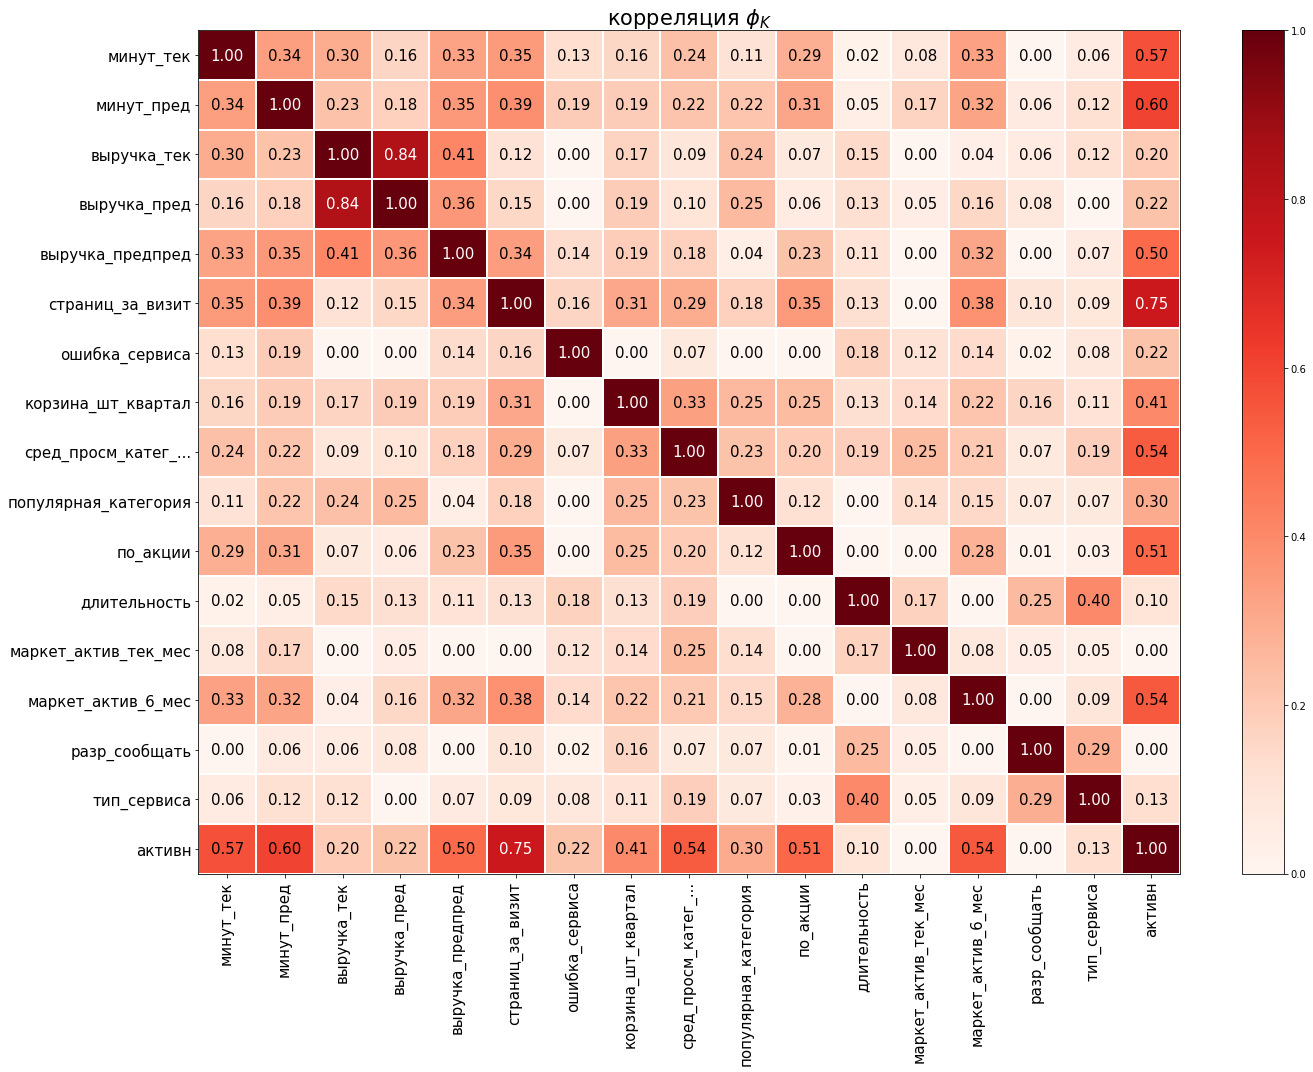

In [44]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Reds',
    title=r'корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)) 

**Вывод по разделу**
<br>В результате выполненного корреляционного анализа значительной корреляции между признаками не обнаружилось. Утечки данных также не было обнаружено.

## Пайплайн

В пайплайне будут сравниваться четыре модели: KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression и  SVC. Для каждой из них будет подбираться как минимум один гиперпараметр. Для сравнения моделей была выбрана метрика roc_auc. ROC-AUC — это всеохватывающая метрика качества классификации. Она учитывает работу модели при всех возможных значениях порогов и поэтому не зависит от одного конкретного. Она применяется когда необходимо оценить качество работы модели вне зависимости от выбранного порога вероятности. Метрику можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другими.

In [45]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [46]:
# Деление на выборки
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['id', 'активн'], axis=1),
    data['активн'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data['активн'])

X_train.shape, X_test.shape

((972, 16), (324, 16))

In [47]:
# кодирование целевого признака
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [48]:
#колонки для кодирования
ohe_columns = ['популярная_категория']
ord_columns = ['разр_сообщать', 'тип_сервиса']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'по_акции', 
               'сред_просм_катег_за_визит', 'корзина_шт_квартал', 'ошибка_сервиса', 'страниц_за_визит', 
               'выручка_предпред', 'выручка_пред', 'выручка_тек', 'минут_пред', 'минут_тек']

In [49]:
ohe_pipe = Pipeline([('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, 
                                                         strategy='most_frequent')), 
                     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])

In [50]:
ord_pipe = Pipeline([('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('ord',  OrdinalEncoder(categories=[
                         ['нет', 'да'],
                         ['стандарт', 'премиум']],
                                             handle_unknown='use_encoded_value', unknown_value=np.nan)),
                     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

In [51]:
data_preprocessor = ColumnTransformer([('ohe', ohe_pipe, ohe_columns),
                                       ('ord', ord_pipe, ord_columns),
                                       ('num', StandardScaler(), num_columns)], 
                                      remainder='passthrough')

In [52]:
pipe_final = Pipeline([('preprocessor', data_preprocessor),
                       ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))])

In [53]:
param_grid = [
    # модель DecisionTreeClassifier
    {'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
     'models__max_depth': range(2, 10),
     'models__max_features': range(2, 10),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
    
    # модель KNeighborsClassifier
    {'models': [KNeighborsClassifier()],
     'models__n_neighbors': range(2, 5),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},

    # модель LogisticRegression
    {'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
     'models__C': range(1, 5),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
    
    # модель SVC
    {'models': [SVC(kernel='poly', probability=True, random_state=RANDOM_STATE)],
     'models__degree': range(2, 20),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}
]

In [54]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1)

In [55]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImpu...
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        probability=True,
                                                        random_state=42)],
                                         'models__degree': range(2, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [56]:
display('roc_auc лучшей модели на тренировочной выборке:', randomized_search.best_score_)

'roc_auc лучшей модели на тренировочной выборке:'

0.8887985530985529

In [57]:
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]

In [58]:
roc_auc_score(y_test, y_test_pred)

0.9167981232051127

In [59]:
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)

DummyClassifier(random_state=42, strategy='most_frequent')

In [60]:
dum_pred = dummy_clf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, dum_pred)

0.5

**Вывод по разделу**
<br> В результате сравнения моделей (KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression и SVC) в пайплайне лучшей моделью оказался метод SVC с параметром со степенью полиномиальной функции - 4. Для сравнения моделей была выбрана метрика ROC-AUC. ROC-AUC — это всеохватывающая метрика качества классификации. Она учитывает работу модели при всех возможных значениях порогов и поэтому не зависит от одного конкретного. Она применяется когда необходимо оценить качество работы модели вне зависимости от выбранного порога вероятности. Метрику можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другими.
<br>На тренировочных данных ROC-AUC = 0.897, а на тестовых 0.908. Это говорит о высоком качестве модели. У константной модели ROC-AUC на тестовой выборке составил 0,5.

## Анализ важности признаков

Вначале обучим лучшую модель. Для этого масштабируем и закодируем признаки

In [61]:
# Создадим датафреймы из train и test, обработанных с помощью ранее написаного ColumnTransformer
X_train = pd.DataFrame(data=data_preprocessor.fit_transform(X_train), 
                       columns=data_preprocessor.get_feature_names_out())
X_test = pd.DataFrame(data=data_preprocessor.fit_transform(X_test), 
                      columns=data_preprocessor.get_feature_names_out())

In [62]:
X_train.head(3)

,ohe__популярная_категория_Косметика и аксесуары,ohe__популярная_категория_Кухонная посуда,ohe__популярная_категория_Мелкая бытовая техника и электроника,ohe__популярная_категория_Техника для красоты и здоровья,ohe__популярная_категория_Товары для детей,ord__разр_сообщать,ord__тип_сервиса,num__маркет_актив_6_мес,num__маркет_актив_тек_мес,num__длительность,num__по_акции,num__сред_просм_катег_за_визит,num__корзина_шт_квартал,num__ошибка_сервиса,num__страниц_за_визит,num__выручка_предпред,num__выручка_пред,num__выручка_тек,num__минут_пред,num__минут_тек
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.228498,-0.034940,-0.386673,-0.678649,-0.926450,0.554520,1.446808,1.973431,-1.451803,0.308218,0.921997,1.641373,-1.744172
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.829033,-0.034940,-1.626840,-0.354956,0.559539,1.048557,-1.130716,-1.316315,-0.714636,2.067366,-1.724921,-0.647600,-0.064910
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.030104,1.380136,1.555325,-0.597726,1.302533,-0.927589,-0.615212,0.708144,-0.629125,-1.204835,-1.714569,-0.138940,-0.784593


In [63]:
# Создадим лучшую модель
model = SVC(degree=4, kernel='poly', probability=True, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

SVC(degree=4, kernel='poly', probability=True, random_state=42)

In [64]:
explainer = shap.KernelExplainer(lambda x: model.predict_proba(x)[:, 1], shap.sample(X_train, 10))

# Рассчет SHAP значений для тестовых данных
shap_values = explainer(shap.sample(X_test, 10))

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/conda

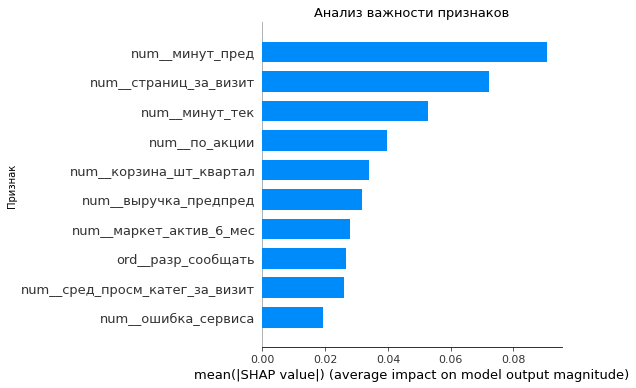

In [65]:
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.title('Анализ важности признаков')
plt.ylabel('Признак')
shap.summary_plot(shap_values, plot_type='bar', max_display=10)

plt.show()

**Вывод по разделу**
<br> Как видно из графика, наиболее сильно на целевой признак влияют: время, проведенное на сайте в предыдущем месяце; количество посещенных страниц за визит; время, проведенное на сайте в текущем месяце; доля покупок по акции. Таким образом можно повысить активность клиентов как можно дольше удерживая их на сайте, предлагать больше товаров по акции, увеличить число рассылок, звонков, показов рекламы и прочего для клиентов, активность которых снизилась.

## Сегментация покупателей

Для исследования выделим сегмент клиентов с наибольшим снижением активности среди премиальных и стандартных клиентов. Оценим, как снижение активности скажется на прибыли. Для этого объединим data и data_4.
<br>Кроме того по ходу анализа будем менять признаки и, используя построенную модель проверять, как от этого изменится активность клиентов.

Первым делом объединение

In [66]:
data = data.merge(data_4, on='id')

In [67]:
display(len(data))
data.head(3)

1296

,id,активн,тип_сервиса,разр_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,по_акции,популярная_категория,сред_просм_катег_за_визит,корзина_шт_квартал,ошибка_сервиса,страниц_за_визит,выручка_предпред,выручка_пред,выручка_тек,минут_пред,минут_тек,прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10,4.16
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13,3.13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13,4.87


Проверим, насколько активные клиенты приносят больше прибыли, чем неактивные

In [68]:
for i in ['выручка_предпред', 'выручка_пред', 'выручка_тек', 'прибыль']:
    print(i)
    print(data.groupby('активн')[i].mean())
    print()

выручка_предпред
активн
Прежний уровень    4933.475062
Снизилась          4678.281377
Name: выручка_предпред, dtype: float64

выручка_пред
активн
Прежний уровень    4932.559227
Снизилась          4971.674089
Name: выручка_пред, dtype: float64

выручка_тек
активн
Прежний уровень    5197.704115
Снизилась          5303.671660
Name: выручка_тек, dtype: float64

прибыль
активн
Прежний уровень    3.995574
Снизилась          4.001154
Name: прибыль, dtype: float64



Можно сделать вывод, что активность не особо сильно влияет на прибыль и выручку от клиентов. Поэтому для расчета активности данную фичу использовать не будем.

Сейчас узнаем, какой класс пользователей (премиальные или стандартные) сильнее всего убавил в активности

In [69]:
data['тип_сервиса'].value_counts()

стандарт    922
премиум     374
Name: тип_сервиса, dtype: int64

In [70]:
premium = data.query('тип_сервиса == "премиум"')
standart = data.query('тип_сервиса == "стандарт"')
len(temp_1) + len(temp_2)

1296

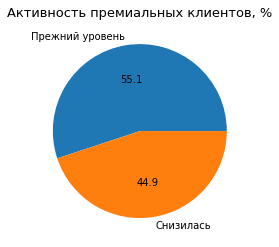

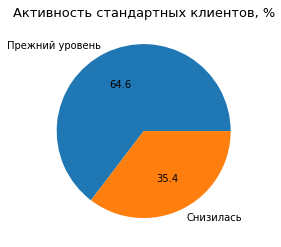

In [71]:
temp = data.pivot_table(index='активн', columns='тип_сервиса', values='id', aggfunc='count')
plt.pie(temp['премиум'], autopct='%.1f', labels=temp.index)
plt.title('Активность премиальных клиентов, %')
plt.show()
plt.pie(temp['стандарт'], autopct='%.1f', labels=temp.index)
plt.title('Активность стандартных клиентов, %');

Видно, что наибольшее снижение активности наблюдается для премиальных клиентов. С данной группой пользователей и будем работать.
<br> Просмотрим, какие показатели у премиальных клиентов отличаются от показателей стандартных клиентов.

In [72]:
premium.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,по_акции,сред_просм_катег_за_визит,корзина_шт_квартал,ошибка_сервиса,страниц_за_визит,выручка_предпред,выручка_пред,выручка_тек,минут_пред,минут_тек,прибыль
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,215943.577540,4.124332,3.930481,724.288770,0.335134,2.997326,3.008021,4.272727,8.320856,4823.598930,4998.327540,5269.645187,12.855615,13.350267,3.977032
std,380.401295,1.013222,0.717817,231.873954,0.258334,1.235096,1.972312,2.035991,4.080785,314.048424,707.942765,878.258599,4.079703,4.428495,1.044854
min,215349.000000,0.900000,3.000000,150.000000,0.110000,1.000000,0.000000,0.000000,1.000000,4119.000000,2909.000000,2758.700000,5.000000,4.000000,0.860000
25%,215602.750000,3.500000,3.000000,568.500000,0.170000,2.000000,1.000000,3.000000,5.000000,4584.750000,4548.500000,4687.875000,10.000000,10.000000,3.162500
50%,215914.000000,4.100000,4.000000,763.500000,0.240000,3.000000,3.000000,4.000000,8.000000,4792.000000,5022.500000,5198.200000,12.500000,13.000000,4.010000
75%,216278.250000,4.800000,4.000000,909.750000,0.320000,4.000000,4.000000,6.000000,11.000000,5008.750000,5498.750000,5883.500000,16.000000,17.000000,4.667500
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000,5653.000000,6869.500000,7605.300000,23.000000,23.000000,7.430000


In [73]:
standart.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,по_акции,сред_просм_катег_за_визит,корзина_шт_квартал,ошибка_сервиса,страниц_за_визит,выручка_предпред,выручка_пред,выручка_тек,минут_пред,минут_тек,прибыль
count,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000
mean,216022.134490,4.309978,4.041215,553.754881,0.313959,3.377440,2.774403,4.148590,8.133406,4841.314534,4926.838395,5225.298482,13.720174,13.154013,4.006085
std,369.640711,1.009277,0.685220,239.038212,0.245219,1.386554,1.971864,1.916453,3.937154,341.125793,697.206436,815.965286,3.852859,4.136137,0.997679
min,215350.000000,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000,4098.000000,2890.000000,2952.200000,5.000000,4.000000,0.860000
25%,215714.500000,3.800000,4.000000,357.000000,0.170000,2.000000,1.000000,3.000000,5.000000,4585.250000,4494.500000,4718.125000,11.000000,10.000000,3.340000
50%,216025.500000,4.300000,4.000000,546.500000,0.240000,3.000000,3.000000,4.000000,8.000000,4817.500000,4998.500000,5174.650000,14.000000,13.000000,4.060000
75%,216342.750000,5.000000,5.000000,746.750000,0.300000,4.000000,4.000000,5.000000,11.000000,5086.000000,5381.875000,5701.950000,17.000000,16.000000,4.670000
max,216646.000000,6.600000,5.000000,1064.000000,0.990000,6.000000,10.000000,9.000000,19.000000,5663.000000,6809.000000,7799.400000,23.000000,23.000000,7.210000


Премиальные граждане: 
1. чуть меньше подвержены рекламе, рассылкам с предложениями и пр. за 6 месяцев; 
2. больше времени зарегестрированы на сайте; 
3. просматривают меньше категорий; 
4. имеют больше товаров в корзине; 
5. приносят меньше прибыли.

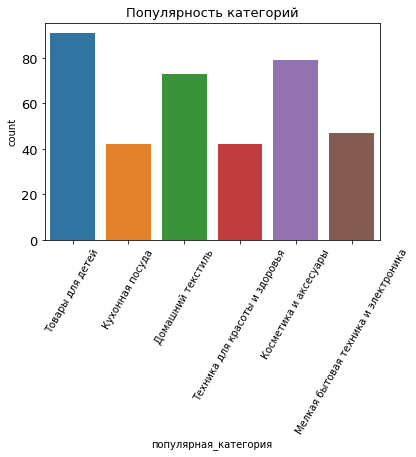

In [74]:
sns.countplot(data = premium, x='популярная_категория')
plt.title('Популярность категорий')
plt.xticks(rotation=60)
plt.show()

Наиболее популярные категории для премиальных клиентов это товары для детей, косметика и аксуссуары и домашний текстиль

Для определения активности в будущем всех клиентов изменим параметры, на которые Компания может повлиять и которые находтся в первой десятке важных признаков (обнаруженных при модлировании). Это `маркет_актив_6_мес, ошибка_сервиса, по_акции`. Первый признак увеличим до максимума, второй уменьшим до 0, а третий сделаем равным 0,9. Также добавим в data расчитанные значения активности.

In [75]:
temp = data.drop(['id', 'активн', 'прибыль'], axis=1)
temp = pd.DataFrame(data=data_preprocessor.fit_transform(temp), 
                       columns=data_preprocessor.get_feature_names_out())
predicts = model.predict(temp)

In [76]:
data['модель'] = predicts
data.head(3)

,id,активн,тип_сервиса,разр_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,по_акции,популярная_категория,сред_просм_катег_за_визит,корзина_шт_квартал,ошибка_сервиса,страниц_за_визит,выручка_предпред,выручка_пред,выручка_тек,минут_пред,минут_тек,прибыль,модель
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10,4.16,1
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13,3.13,0
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13,4.87,1


In [77]:
new_data = data.copy()

In [78]:
#повышаем маркетинговую активность до максимума, ошибки до нуля, продажу товаров по акции до 90% на человека
new_data['маркет_актив_6_мес'] = new_data['маркет_актив_6_мес'].max()
new_data['ошибка_сервиса'] = 0
new_data['по_акции'] = 0.9

In [79]:
new_data.head(3)

,id,активн,тип_сервиса,разр_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,по_акции,популярная_категория,сред_просм_катег_за_визит,корзина_шт_квартал,ошибка_сервиса,страниц_за_визит,выручка_предпред,выручка_пред,выручка_тек,минут_пред,минут_тек,прибыль,модель
0,215349,Снизилась,премиум,да,6.6,4,819,0.9,Товары для детей,4,4,0,5,4472.0,5216.0,4971.6,12,10,4.16,1
1,215350,Снизилась,стандарт,нет,6.6,3,539,0.9,Домашний текстиль,5,2,0,5,4826.0,5457.5,5058.4,8,13,3.13,0
2,215351,Снизилась,стандарт,да,6.6,5,896,0.9,Товары для детей,5,0,0,4,4793.0,6158.0,6610.4,11,13,4.87,1


In [80]:
new_data.drop(['id', 'активн', 'прибыль', 'модель'], axis=1, inplace=True)

In [81]:
# Создадим датафрейм из новых данных, обработанных с помощью ранее написаного ColumnTransformer
new_data = pd.DataFrame(data=data_preprocessor.fit_transform(new_data), 
                       columns=data_preprocessor.get_feature_names_out())

In [82]:
predicts = model.predict(new_data)

In [83]:
data['маркет_макс__ошибки_0__акция_90'] = predicts

In [84]:
# Посчитаем, скольким людям раньше модель предсказывала снижение активности а теперь пророчит прежнюю активность
len(data.query('модель == 1 & маркет_макс__ошибки_0__акция_90 == 0'))

99

In [85]:
len(data.query('модель == 0 & маркет_макс__ошибки_0__акция_90 == 1'))

3

Увеличение маркетинга до максимума, уменьшение ошибок на сервере до нуля и продажа 9 из 10 товаров по акции сохранит активность 99 клиентов, но так компания потеряет 3 клиентов (с вероятностью примерно 0,9). Поскольку активнсть мало влияет на прибыль, то от принятия таких мер компания понесет убытки.

In [86]:
# Проверим, насколько такие меры помогут удержать активность премиальных клиентов
len(data.query('тип_сервиса == "премиум" & модель == 1 & маркет_макс__ошибки_0__акция_90 == 0'))

30

In [87]:
len(data.query('тип_сервиса == "премиум" & модель == 1 & маркет_макс__ошибки_0__акция_90 == 0')) * 100 / \
len(data.query('тип_сервиса == "премиум" & модель == 1'))

21.58273381294964

In [88]:
len(data.query('тип_сервиса == "премиум" & модель == 0 & маркет_макс__ошибки_0__акция_90 == 1'))

0

Принятые меры позволят сохранить активность для 30 премиальных клиентов (это 22% от таких премиальных, которым модель при начальных параметрах пророчила снижение активности)

**Вывод по разделу**
<br>В рамках исследования был проверен сегмент с наибольшим снижением активности среди премиальных и стандартных клиентов. Наиболее сильно активность просела у премиальных клиентов.
Премиальные граждане в отличае от стандартных:
1. чуть меньше подвержены рекламе, рассылкам с предложениями и пр. за 6 месяцев;
2. больше времени зарегестрированы на сайте;
3. просматривают меньше категорий;
4. имеют больше товаров в корзине;
5. приносят меньше прибыли.

<br>Также можно сделать вывод, что активность не особо сильно влияет на прибыль и выручку от клиентов.
<br>Для определения активности в будущем всех клиентов изменим параметры, на которые Компания может повлиять и которые находтся в первой десятке важных признаков (обнаруженных при модлировании). Это `маркет_актив_6_мес, ошибка_сервиса, по_акции`. Первый признак был увеличен до максимума, второй уменьшен до 0, а третий принят равным 0,9. Увеличение маркетинга до максимума, уменьшение ошибок на сервере до нуля и продажа 9 из 10 товаров по акции сохранит активность 99 клиентов, но так компания потеряет 3 клиентов (с вероятностью примерно 0,9). Поскольку активнсть мало влияет на прибыль, то от принятия таких мер компания понесет убытки. Принятые меры позволят сохранить активность для 30 премиальных клиентов (это 22% от таких премиальных, которым модель при начальных параметрах пророчила снижение активности)

## Выводы

Общая информация
<br>Интернет-магазин продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
<br>Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

<br>Описание данных
<br>Вся информация находится в четырех датасетах. 
<br>Первый содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. Состоит из 1300 строк и 13 колонок. Дубликаты и повторяющиеся значения отсутствуют.
<br>Второй содержит информацию о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом. Состоит из 3900 строк и 3 колонок. Дубликаты и повторяющиеся значения отсутствуют.
<br>Третий содержит информацию с данными о времени (в минутах), которое покупатель провёл на сайте в течение некоторого периода. Состоит из 2600 строк и 3 колонок. Дубликаты и повторяющиеся значения отсутствуют.
<br>Четвертый содержит информацию с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю. Состоит из 1300 строк и 2 колонок. Дубликаты и повторяющиеся значения отсутствуют.
<br>Имеется одно аномальное значение в data_2 (будет устранено в разделе EDA), тип данных в колонке "прибыль" в data_4 будет откорректрован в следующем разделе.

<br>Предобработка данных
<br>В результате выполненной предобработки типы данных были откорректированы, а некорректные наименования в колонках устранены.

<br>Исследовательский анализ данных
<br>Как видно из проведенного анализа большинство клиентов сохранили свою активность на прежнем уровне. Также большинство не пользуется премиальной подпиской. Большая часть пользователей интересуется дополнительными предолежниями о товаре. Средний просмотр категорий за визит имеет приблизительно номальное распределение с наиболее частым значением = 3. Чаще всего в корзине пользователей накапливается до 5 неоплаченных товаров. Число сбоев тоже имеет нормальное распределение со средним значением в районе 4 сбоев. Наиболее чаще пользователей интересуют товары для детей и домотканный текстиль. Наименее популярная категория - кухонная посуда.
<br>Имеет место дисбаланс классов при делении пользователей по покупательской активности, типе подписки, разрешению на уведомления.
<br>Пользователи, у которых активность снизилась имеют тенденцию покупать больше товаров по акциям. Судя по всему такое поведение связано с их личными финансовыми трудностями, а не с работой сервиса.
<br> Прослеживается тенденция увеличения выручки от периода к периоду, так за текущий период сервис заработал больше всего выручки (34,9 % от всей выручки за 3 месяца). При этом время проведенное при просмотре товаров за последний месяц снизилось. Судя по всему пользователи стали быстрее находить нужные им товары.
<br>Среднемесячная прибыль покапателя имеет нормальное распределение со средним значением в районе 4.

<br>Объединение таблиц
<br>Объединение data_1, data_2 и data_3 прошло успешно. Идентичных строк не появилось, все данные попали в итоговый датафрейм.

<br>Корреляционный анализ
<br>В результате выполненного корреляционного анализа значительной корреляции между признаками не обнаружилось. Утечки данных также не было обнаружено.

<br>Пайплайн
<br> В результате сравнения моделей (KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression и SVC) в пайплайне лучшей моделью оказался метод SVC с параметром со степенью полиномиальной функции - 4. Для сравнения моделей была выбрана метрика ROC-AUC. ROC-AUC — это всеохватывающая метрика качества классификации. Она учитывает работу модели при всех возможных значениях порогов и поэтому не зависит от одного конкретного. Она применяется когда необходимо оценить качество работы модели вне зависимости от выбранного порога вероятности. Метрику можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другими.
<br>На тренировочных данных ROC-AUC = 0.897, а на тестовых 0.908. Это говорит о высоком качестве модели. У константной модели ROC-AUC на тестовой выборке составил 0,5.

<br>Анализ важности признаков
<br>Как видно из графика, наиболее сильно на целевой признак влияют: время, проведенное на сайте в предыдущем месяце; количество посещенных страниц за визит; время, проведенное на сайте в текущем месяце; доля покупок по акции. Таким образом можно повысить активность клиентов как можно дольше удерживая их на сайте, предлагать больше товаров по акции, увеличить число рассылок, звонков, показов рекламы и прочего для клиентов, активность которых снизилась.

<br>Сегментация покупателей
<br>В рамках исследования был проверен сегмент с наибольшим снижением активности среди премиальных и стандартных клиентов. Наиболее сильно активность просела у премиальных клиентов.
Премиальные граждане в отличае от стандартных:
1. чуть меньше подвержены рекламе, рассылкам с предложениями и пр. за 6 месяцев;
2. больше времени зарегестрированы на сайте;
3. просматривают меньше категорий;
4. имеют больше товаров в корзине;
5. приносят меньше прибыли.

<br>Также можно сделать вывод, что активность не особо сильно влияет на прибыль и выручку от клиентов.
<br>Для определения активности в будущем всех клиентов изменим параметры, на которые Компания может повлиять и которые находтся в первой десятке важных признаков (обнаруженных при модлировании). Это `маркет_актив_6_мес, ошибка_сервиса, по_акции`. Первый признак был увеличен до максимума, второй уменьшен до 0, а третий принят равным 0,9. Увеличение маркетинга до максимума, уменьшение ошибок на сервере до нуля и продажа 9 из 10 товаров по акции сохранит активность 99 клиентов, но так компания потеряет 3 клиентов (с вероятностью примерно 0,9). Поскольку активнсть мало влияет на прибыль, то от принятия таких мер компания понесет убытки. Принятые меры позволят сохранить активность для 30 премиальных клиентов (это 22% от таких премиальных, которым модель при начальных параметрах пророчила снижение активности).
<br>**Рекомендация:** Поскольку большая часть пользователей разрешает сообщать им о новых товарах, то следует увеличить количество товаров в популярной для них категории и чаще сообщать об их наличии, почаще устраивать акции - это поможет удержать клиентов, но снизит прибыль.

<br>**Вывод по задаче определения снижения активности в будущем**
<br>С целью определения активности в последующие месяцы необходимы данные, которые будут описывать активность этих клиентов в будущем. По данным на текущий момент времени можно точно сказать, снизилась или осталась преженй активность клиентов на текущий момент (что уже было сделано до начала исследования). По сути применяя модели мы проверяли, насколько точно уже была присвоена категория по снижению активности клиентов.